## Sentiment Analysis

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/sentiment analysis project'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/sentiment analysis project


In [72]:
# import modules needeed
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

# download stopwords (we're gonna need it later)
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# load data
print("Loading data...")
df = pd.read_csv("./data/training.1600000.processed.noemoticon.csv", encoding = 'latin', header = None)
# show the first five rows of data (to check if everything's fine)
df.head()

Loading data...


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
# change columns names for reference
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
# show the first five rows of data (now it has proper headers)
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
# drop useless columns
df = df.drop(['id', 'date', 'flag', 'user'], axis = 1)
# show the first five rows of data (to verify again)
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
# count dataset samples to know how many of each class we have
df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [14]:
# clean text to remove users, links and stopwords and then split it in tokens
def clean_text(text):
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    
    return " ".join(tokens)

# apply clean_text function in our data
df.text = df.text.apply(lambda x: clean_text(x))
# show the first five rows of data (to verify again)
df.head()

,target,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see


In [15]:
# set 80% for our data to train
train_size = 0.8

# split our data into train set (80%) and test set (20%)
train_data, test_data = train_test_split(df, test_size = 1 - train_size, random_state = 0, stratify = df.target)

# length of each set
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

# how many examples of each class there is in each set
print("Train data distr: \n", train_data.target.value_counts())
print("Test data distr: \n", test_data.target.value_counts())

Train data size:  1280000
Test data size:  320000
Train data distr: 
 4    640000
0    640000
Name: target, dtype: int64
Test data distr: 
 4    160000
0    160000
Name: target, dtype: int64


In [0]:
# create a tokenizer
tokenizer = Tokenizer()
# fit the tokenizer in the train text
tokenizer.fit_on_texts(train_data.text)

In [0]:
# get max length of the train data
max_length = max([len(s.split()) for s in train_data.text])

# pad sequences in x_train data set to the max length
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = max_length)
# pad sequences in x_test data set to the max length
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = max_length)

In [0]:
# create a label encoder
encoder = LabelEncoder()
# enconde labels (0 or 1) in train data
encoder.fit(train_data.target.to_list())

# transform labels in y_train and y_test data to the encoded ones
y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

# reshape y_train and y_test data
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [20]:
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape:  (1280000, 50)
x_test shape:  (320000, 50)
y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [0]:
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r',encoding="utf-8")
    lines = file.readlines()
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, embedding_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

# contains the index for each word
vocab = tokenizer.word_index
# total number of words in our vocabulary, plus one for unknown words
vocab_size = len(tokenizer.word_index) + 1
# embedding dimensions
embedding_dim = 200

# load embedding from file
raw_embedding = load_embedding('./data/glove/glove.twitter.27B.200d.txt')
# get vectors in the right order
embedding_matrix = get_weight_matrix(raw_embedding, vocab)

# create the embedding layer
embedding_layer = Embedding(vocab_size, 
                            embedding_dim, 
                            weights = [embedding_matrix], 
                            input_length = max_length, 
                            trainable = False)

In [71]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(200, dropout = 0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))

print(model.summary())

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           58142800  
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 58,476,529
Trainable params: 333,729
Non-trainable params: 58,142,800
_________________________________________________________________
None


In [73]:
# train model
BATCH_SIZE = 1024
EPOCHS = 20

ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    validation_split = 0.1, callbacks = [ReduceLROnPlateau])

Train on 1152000 samples, validate on 128000 samples
Epoch 1/20
1152000/1152000 [==============================] - 154s 134us/step - loss: 0.4951 - accuracy: 0.7552 - val_loss: 0.4554 - val_accuracy: 0.7819
Epoch 2/20
1152000/1152000 [==============================] - 153s 133us/step - loss: 0.4656 - accuracy: 0.7757 - val_loss: 0.4449 - val_accuracy: 0.7873
Epoch 3/20
1152000/1152000 [==============================] - 153s 133us/step - loss: 0.4546 - accuracy: 0.7828 - val_loss: 0.4345 - val_accuracy: 0.7938
Epoch 4/20
1152000/1152000 [==============================] - 153s 133us/step - loss: 0.4470 - accuracy: 0.7873 - val_loss: 0.4330 - val_accuracy: 0.7958
Epoch 5/20
1152000/1152000 [==============================] - 153s 132us/step - loss: 0.4414 - accuracy: 0.7903 - val_loss: 0.4287 - val_accuracy: 0.7972
Epoch 6/20
1152000/1152000 [==============================] - 153s 133us/step - loss: 0.4366 - accuracy: 0.7933 - val_loss: 0.4293 - val_accuracy: 0.7981
Epoch 7/20
1152000/1152

In [74]:
# evaluate model
score = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

320000/320000 [==============================] - 5s 14us/step
Test loss: 0.4286909240245819
Test accuracy: 0.8010437488555908


In [0]:
# save model
model.save('model11.h5')

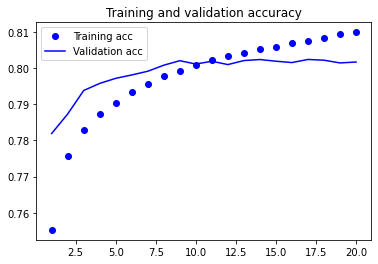

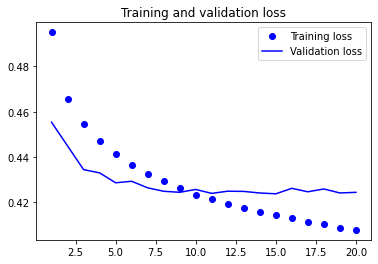

In [76]:
# plotting model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [77]:
# decode score prediction from the model, to be 0 or 1
def decode_prediction(prediction):
    return 0 if prediction < 0.5 else 1

# load model
model = load_model('model11.h5')

# test model with a new query
data_string = clean_text("@taylorswift i love it! it's amazing")
# tokenize and pad query test as in training
data_string = pad_sequences(tokenizer.texts_to_sequences([data_string]),
                        maxlen = max_length)

# get model prediction
prediction = model.predict([data_string])[0]
# get decode prediction
label = decode_prediction(prediction)

print("Prediction: {} Score: {}".format(prediction, label))

Prediction: [0.97490746] Score: 1
